In [1]:
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Activation
import sklearn
from sklearn import metrics
import time

In [ ]:
transform = torchvision.transforms.ToTensor()

training_data = torchvision.datasets.MNIST(
    root="/files/",
    train=True,
    download=True,
    transform=transform,
)

testing_data = torchvision.datasets.MNIST(
    root="/files/",
    train=False,
    download=True,
    transform=transform,
)

train_subset, val_subset = torch.utils.data.random_split(
        training_data, [50000, 10000], generator=torch.Generator().manual_seed(1))



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



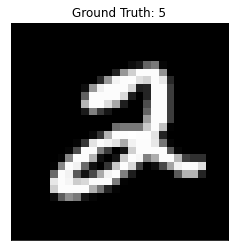

In [ ]:
plt.imshow(training_data[5][0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: 5")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
class MultiLayerPereceptron(nn.Module):
  def __init__(self,in_dim,layer_one_dim,output_dim):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(in_dim,layer_one_dim),
                                nn.ReLU(),
                                nn.Linear(layer_one_dim,output_dim),
                                nn.LogSoftmax())

  def forward(self,x):
    return self.layers(x)

## Set before training ##
epoch_size = 10
n_classes = 10
batch_size = 500
lr = 0.03
## Neural Network ##
MLP = MultiLayerPereceptron(784,128,10).to(device)

training_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=True)

## Set NN in training mode @@
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(MLP.parameters(), lr=lr)
training_losses = []
MLP.train()

epoch_training_loss = []
epoch_val_loss = []
epoch_training_accuracy = []
epoch_val_accuracy = []


prev = time.time()
curr = 0
print(prev)


for e in range(epoch_size):
  ## Calculate Losses ##

  prev = time.time()

  training_losses = []
  val_losses = []
  for x,y in training_dataloader:
    x = x.reshape(x.shape[0],-1)
    one_hot_y = torch.zeros(batch_size, n_classes)
    one_hot_y[range(one_hot_y.shape[0]), y] = 1

    optimizer.zero_grad()

    pred = MLP.forward(x.to(device))
    
    loss = loss_fn(pred,y.to(device))
    training_losses.append(loss.item())

    ## Params only updated for training set ##
    loss.backward()
    optimizer.step()

  for x,y in val_dataloader:
    x = x.reshape(x.shape[0],-1)
    one_hot_y = torch.zeros(batch_size, n_classes)
    one_hot_y[range(one_hot_y.shape[0]), y] = 1

    optimizer.zero_grad()

    pred = MLP.forward(x.to(device))
    
    loss = loss_fn(pred,y.to(device))
    val_losses.append(loss.item())
  
  epoch_training_loss.append(np.mean(training_losses))
  epoch_val_loss.append(np.mean(val_losses))

  with torch.no_grad():
    MLP.eval() # Put model in eval mode

    ## Training Accuracy ##
    num_correct = 0
    for x, y in training_dataloader:
        x = x.reshape(x.shape[0],-1)
        x, y = x.float().to(device), y.float().to(device)
        output = MLP.forward(x)
        prediction = torch.max(output,1)[1]
        num_correct += torch.sum(prediction == y.data)
    epoch_training_accuracy.append(num_correct.item()/len(train_subset))

    ## Testing Accuracy ##
    num_correct = 0
    for x, y in val_dataloader:
        x = x.reshape(x.shape[0],-1)
        x, y = x.float().to(device), y.float().to(device)
        output = MLP.forward(x)
        prediction = torch.argmax(output,dim=1).float()
        num_correct += torch.sum(prediction == y.data)
    epoch_val_accuracy.append(num_correct.item()/len(val_subset))

    curr = time.time()
    print("Epoch " + str(e) + " Duration: " + str(curr - prev))

    MLP.train() # Put model back in train mode

cuda
1678941624.8136518


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0 Duration: 17.223907470703125
Epoch 1 Duration: 14.813448190689087
Epoch 2 Duration: 14.735277652740479
Epoch 3 Duration: 15.324663162231445
Epoch 4 Duration: 16.246692895889282
Epoch 5 Duration: 15.379519939422607


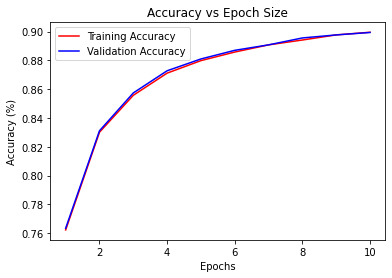

In [ ]:
epoch_values = np.linspace(1,epoch_size,epoch_size)

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch Size")

plt.plot(epoch_values, epoch_training_accuracy, color='red',label="Training Accuracy")
plt.plot(epoch_values, epoch_val_accuracy, color='blue',label="Validation Accuracy")

plt.legend()

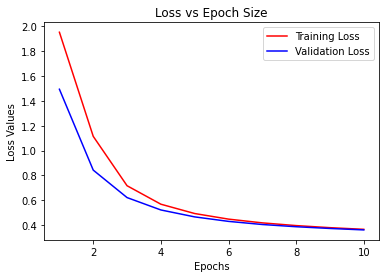

In [ ]:
epoch_values = np.linspace(1,epoch_size,epoch_size)

plt.xlabel("Epochs")
plt.ylabel("Loss Values")
plt.title("Loss vs Epoch Size")

plt.plot(epoch_values, epoch_training_loss, color='red',label="Training Loss")
plt.plot(epoch_values, epoch_val_loss, color='blue',label="Validation Loss")

plt.legend()

In [ ]:
test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=True)


epoch_test_accuracy = 0
with torch.no_grad():
  MLP.eval() # Put model in eval mode

  ## Training Accuracy ##
  num_correct = 0
  for x, y in test_dataloader:
      x = x.reshape(x.shape[0],-1)
      x, y = x.float().to(device), y.float().to(device)
      output = MLP.forward(x)
      prediction = torch.max(output,1)[1]
      num_correct += torch.sum(prediction == y.data)
  epoch_test_accuracy = num_correct.item()/len(testing_data)


epoch_test_accuracy

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9055

# Keras Neural Net

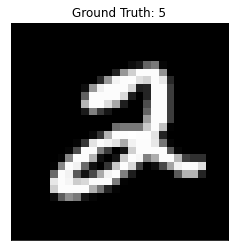

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
one_hot_y_train = keras.utils.to_categorical(y_train, 10)
one_hot_y_test = keras.utils.to_categorical(y_test, 10)
flattened_x_train = x_train.reshape(60000, 784)
flattened_x_test = x_test.reshape(10000, 784)


plt.imshow(x_train[5], cmap='gray', interpolation='none')
plt.title("Ground Truth: 5")
plt.xticks([])
plt.yticks([])
plt.show()

In [12]:
# ## Constructing Neural Network ##
model = Sequential()
model.add(Dense(128, activation="relu", kernel_initializer="random_normal", input_shape=(784,)))
model.add(Dense(10,activation="softmax",kernel_initializer="random_normal"))

## Hyperparameters ##
model.compile(optimizer ='sgd',loss='binary_crossentropy', metrics =['accuracy'])

print(model.summary())


history = model.fit(flattened_x_train,one_hot_y_train,batch_size=500,epochs=10,validation_split=0.166667)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
100/100 [==============================] - 3s 9ms/step - loss: 1.0310 - accuracy: 0.6729 - val_loss: 0.1963 - val_accuracy: 0.7913
Epoch 2/10
100/100 [==============================] - 1s 8ms/step - loss: 0.1719 - accuracy: 0.8038 - val_loss: 0.1370 - val_accuracy: 0.8306
Epoch 3/10
100/100 [==============================] - 1s 8ms/step - loss: 0.1311 - accuracy: 0.8356 - val_loss: 0.1122 - val_accuracy: 0.8552
Epoch 4/10
10

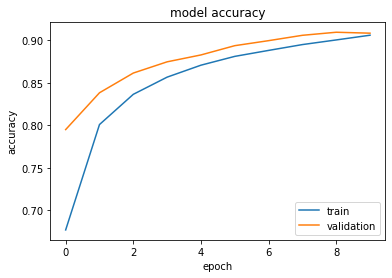

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

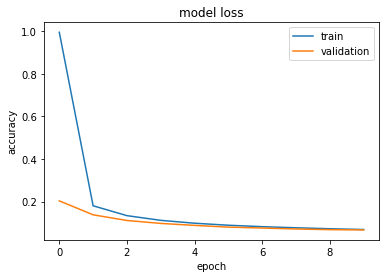

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
## Test Data Evaluation ##
predictions = np.argmax(model.predict(flattened_x_test),axis=1)

print("Accuracy: " +  str(np.sum(predictions == y_test)/len(y_test)))

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.9037


# CNN for MNIST (Keras)

In [2]:
square_x_train = flattened_x_train.reshape(60000,28,28,1)
square_x_test = flattened_x_test.reshape(10000,28,28,1)

NameError: ignored

In [14]:
model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

model.summary()
model.compile(loss="binary_crossentropy",optimizer="sgd",metrics=["acc"])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1600)             

In [15]:
history = model.fit(square_x_train,one_hot_y_train,batch_size=500,epochs=10,validation_split=0.166667)

Epoch 1/10
100/100 [==============================] - 3s 14ms/step - loss: 0.7912 - acc: 0.3202 - val_loss: 0.2103 - val_acc: 0.6762
Epoch 2/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2237 - acc: 0.5570 - val_loss: 0.1435 - val_acc: 0.8166
Epoch 3/10
100/100 [==============================] - 1s 11ms/step - loss: 0.1770 - acc: 0.6849 - val_loss: 0.1061 - val_acc: 0.8765
Epoch 4/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1483 - acc: 0.7562 - val_loss: 0.0876 - val_acc: 0.8974
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1297 - acc: 0.7970 - val_loss: 0.0754 - val_acc: 0.9138
Epoch 6/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1163 - acc: 0.8267 - val_loss: 0.0663 - val_acc: 0.9245
Epoch 7/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1059 - acc: 0.8468 - val_loss: 0.0600 - val_acc: 0.9294
Epoch 8/10
100/100 [==============================] - 1s 11ms/step - 

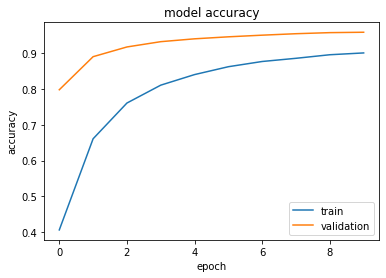

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

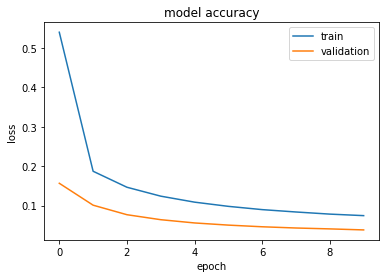

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# GPU with Keras

In [3]:
tf.test.gpu_device_name()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
square_x_train = x_train.reshape(60000,28,28,1)
square_x_test = x_test.reshape(10000,28,28,1)
one_hot_y_train = keras.utils.to_categorical(y_train, 10)
one_hot_y_test = keras.utils.to_categorical(y_test, 10)


model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

model.summary()
model.compile(loss="binary_crossentropy",optimizer="sgd",metrics=["acc"])

history = model.fit(square_x_train,one_hot_y_train,batch_size=500,epochs=10,validation_split=0.166667)

11490434/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                         

KeyboardInterrupt: ignored